# Dynamic circuits RB Example Notebook

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_experiments.framework import BatchExperiment
import sys

sys.path.append("../")
from qiskit_device_benchmarking.bench_code.dynamic_circuits_rb import DynamicCircuitsRB

In [2]:
# put your info here
my_hub = ""
my_group = ""
my_project = ""

service = QiskitRuntimeService(instance="%s/%s/%s" % (my_hub, my_group, my_project))
my_backend = "ibm_pinguino1"

backend = service.backend(my_backend)

## Define sets of qubits and the experiments paramerters 

In [3]:
# define sequences lengths, the sum of lenghts (number of conditionals) must be below the system limit.
# here it is 95<100. If longer sequences are used you need to split the circuits before running the exp.
lengths = [0, 1, 2, 3, 4, 5, 10, 15, 20, 35]

# number of randomizations
n_samples = 3

# number of single qubit cliffords between blocks
n_cliffs_per_meas = 5

# The feedforward latency in dt units, which needs to be known in advance. However it's needed only for Delay/H_CNOT_FFDD blocks.
ff_delay = 2120

# define set of qubits, the measured_qubit and the wanted 1Q dynamic circuits blocks.

qubits = [80, 82, 0, 8, 92]  # ping
measured_qubit = [81]
qubits += measured_qubit
ff_operations = ["I_c0", "Z_c0", "Z_c1"]  # , "I_c1", "Delay"]

# define list of pairs and their 2Q dynamic circuits blocks

pairs = [[82, 81]]
ff_operations_pairs = ["H_CNOT", "H_CNOT_FFDD"]

## Build the experiments

In [4]:
exp_list = []

exp_multi = DynamicCircuitsRB(
    backend=backend,
    physical_qubits=qubits,
    n_blocks=lengths,
    num_samples=n_samples,
    ff_operations=ff_operations,
    cliff_per_meas=n_cliffs_per_meas,
    ff_delay=ff_delay,
    plot_measured_qubit=True,
    plot_summary=True,
)
exp_multi.set_transpile_options(optimization_level=0)
exp_list.append(exp_multi)

# add pairs
for pair in pairs:
    exp_pair = DynamicCircuitsRB(
        backend=backend,
        physical_qubits=pair,
        n_blocks=lengths,
        num_samples=n_samples,
        ff_delay=ff_delay,
        ff_operations=ff_operations_pairs,
        cliff_per_meas=n_cliffs_per_meas,
    )
    exp_pair.set_transpile_options(optimization_level=0)
    exp_list.append(exp_pair)

exp = BatchExperiment(exp_list, flatten_results=True)
exp.set_transpile_options(optimization_level=0)

In [5]:
circuits = exp._transpiled_circuits()

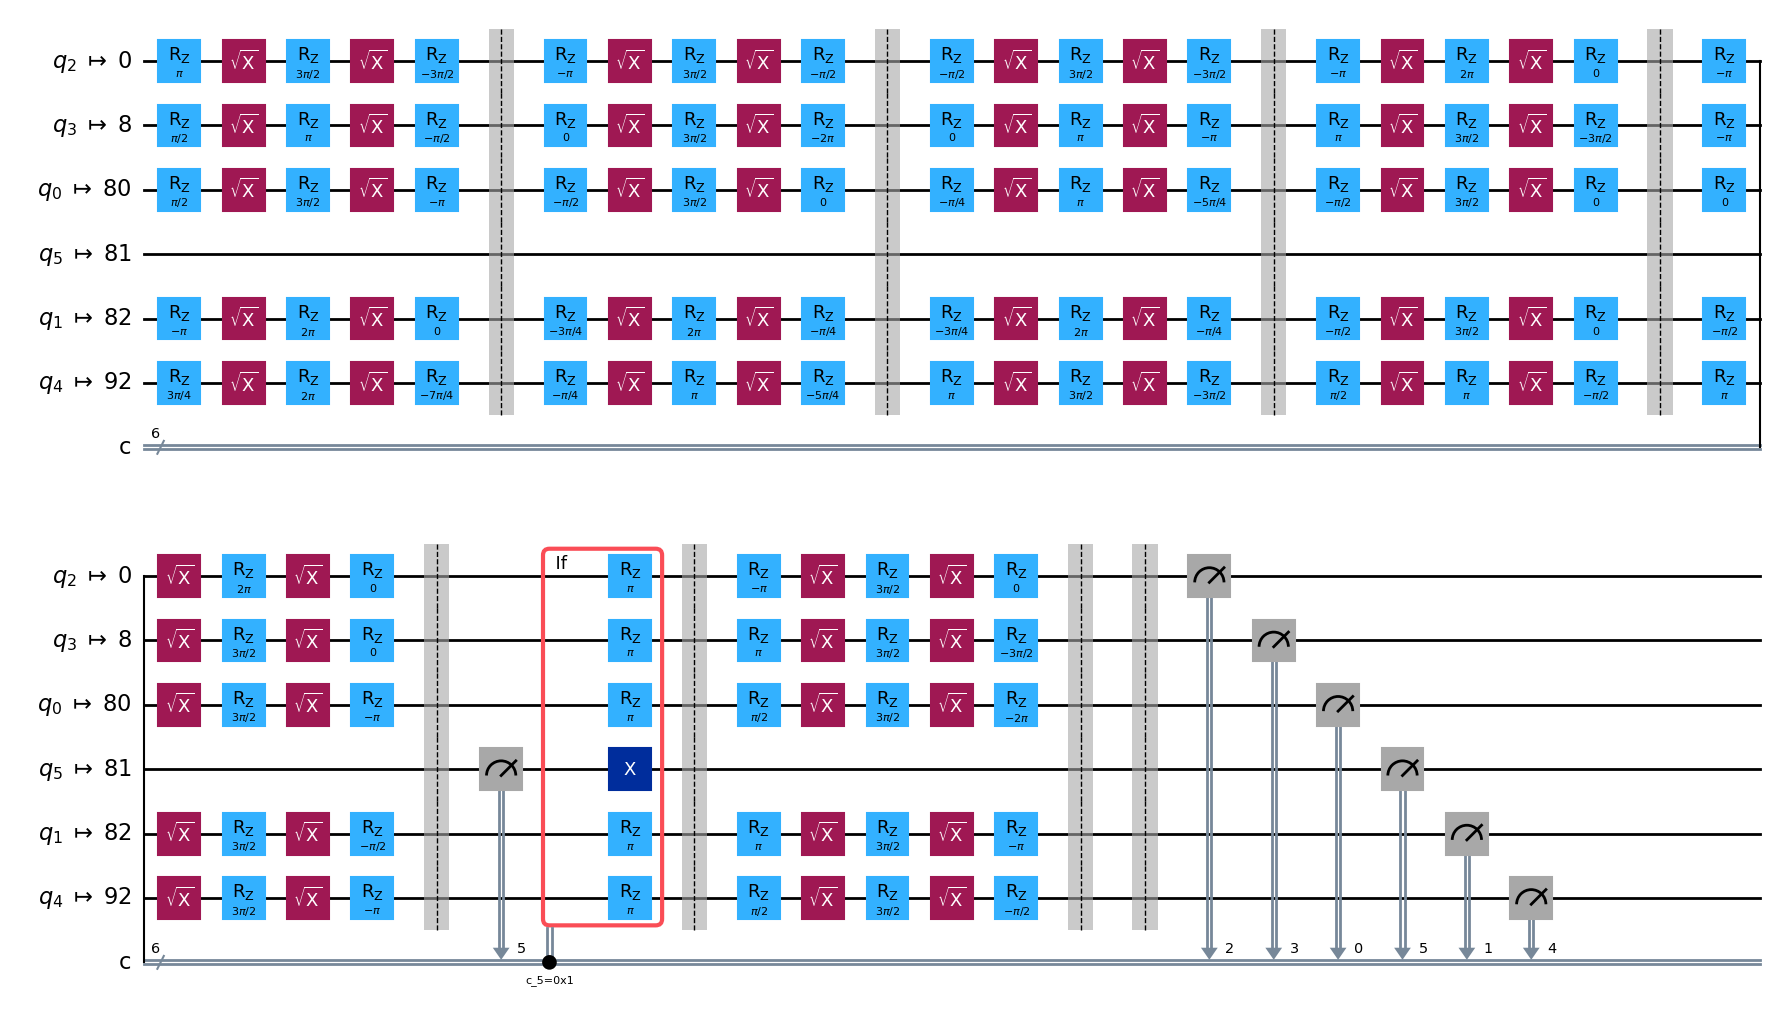

In [6]:
# show some circuit examples
circuits[4].draw("mpl", idle_wires=False, style="iqp")

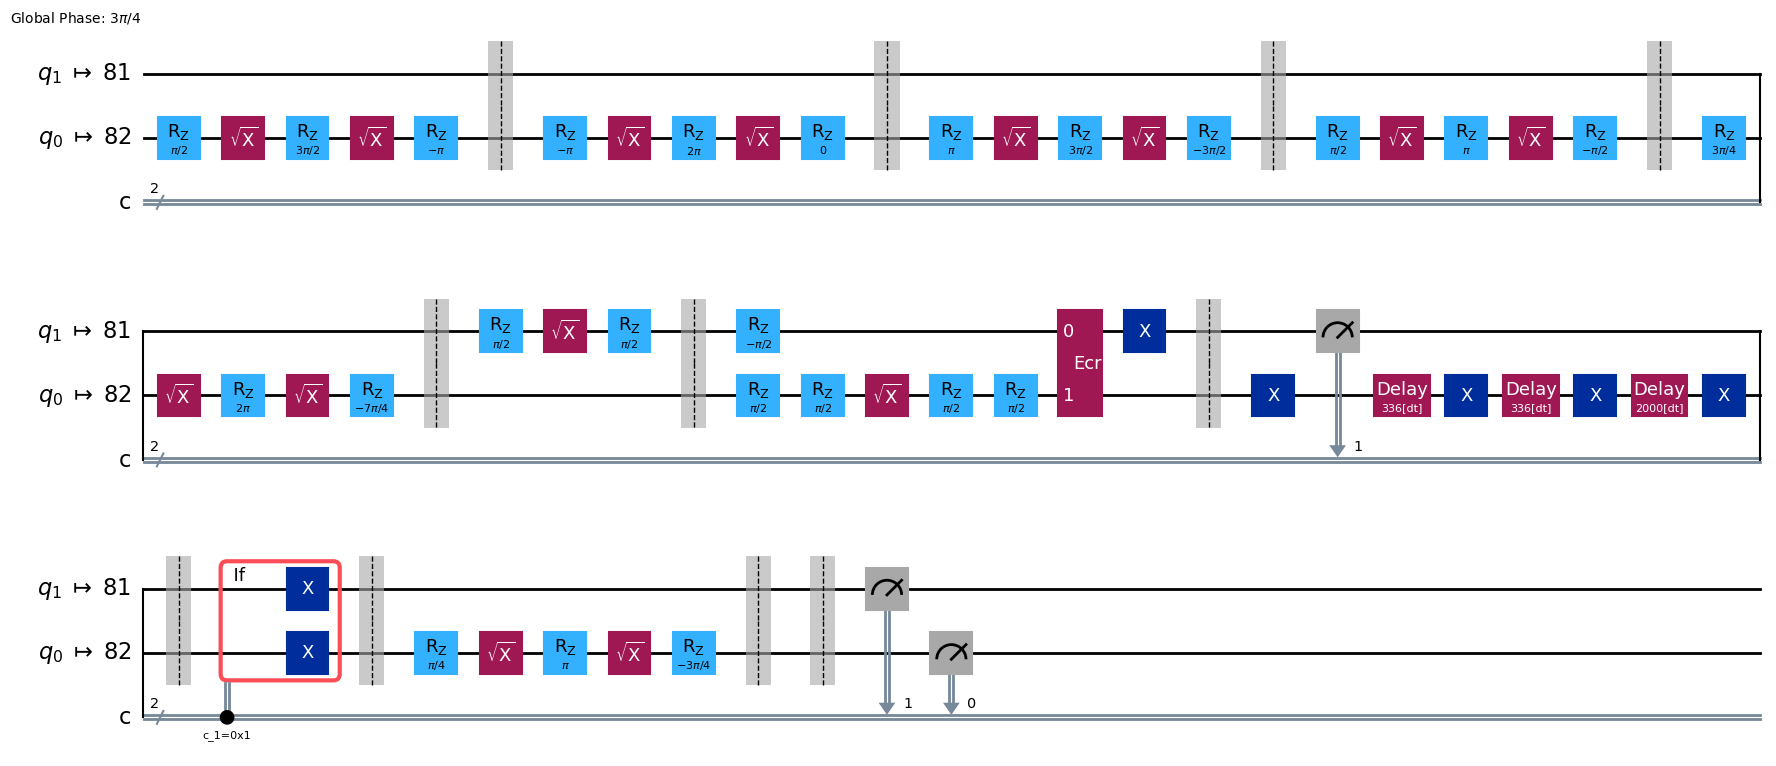

In [7]:
# show some circuit examples
circuits[93].draw("mpl", idle_wires=False, style="iqp")

## Run the experiments
Separate circuits to one job for each seed and block 

In [8]:
job_circuits = []

for ind in range(len(exp.component_experiment())):
    for i in range(n_samples):
        if ind == 0:
            ff_types = ff_operations
        else:
            ff_types = ff_operations_pairs
        for ff_type in ff_types:
            job_circuits.append(
                [
                    circ
                    for circ in circuits
                    if circ.metadata["composite_index"][0] == ind
                    and circ.metadata["composite_metadata"][0]["num_sample"] == i
                    and circ.metadata["composite_metadata"][0]["ff_type"] == ff_type
                ]
            )

In [10]:
# Number of jobs
print(len(job_circuits))

15


In [12]:
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

shots = 300
with Session(backend=backend) as session:
    sampler = Sampler()
    sampler.options.default_shots = shots
    jobs = [sampler.run(circs) for circs in job_circuits]

In [13]:
exp_data = exp._initialize_experiment_data()
exp_data.add_jobs(jobs)
# print(exp_data.job_ids)

In [14]:
exp_data = exp.analysis.run(exp_data)

In [16]:
exp_data.status()

<ExperimentStatus.DONE: 'experiment jobs and analysis have successfully run'>

## Display plots and analysis results

In [27]:
# the first len(qubits)*len(ff_operations) are figure the decay curve of the 1Q dynamic circuits blocks
# then there are two summary figures
print(f"number of qubits: {len(qubits)}, number of blocks: {len(ff_operations)}")

number of qubits: 6, number of blocks: 3


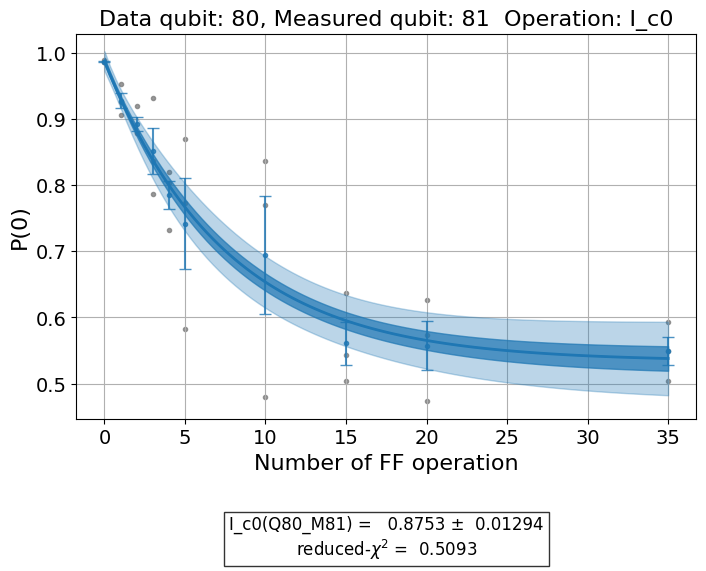

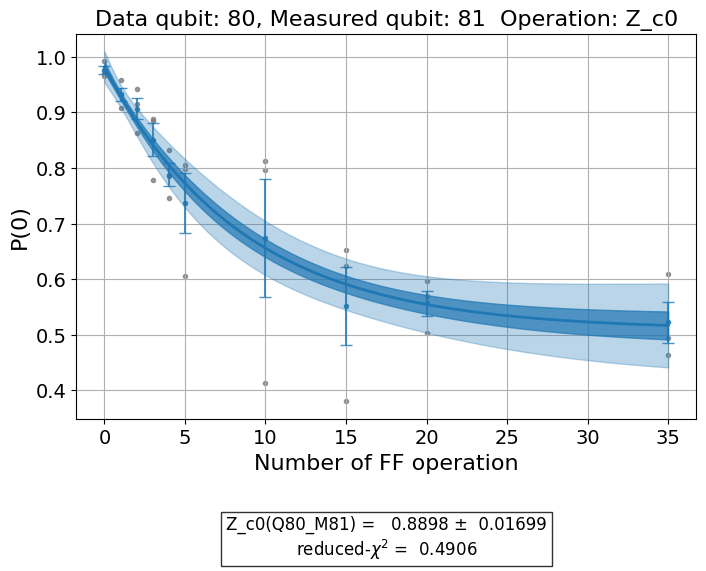

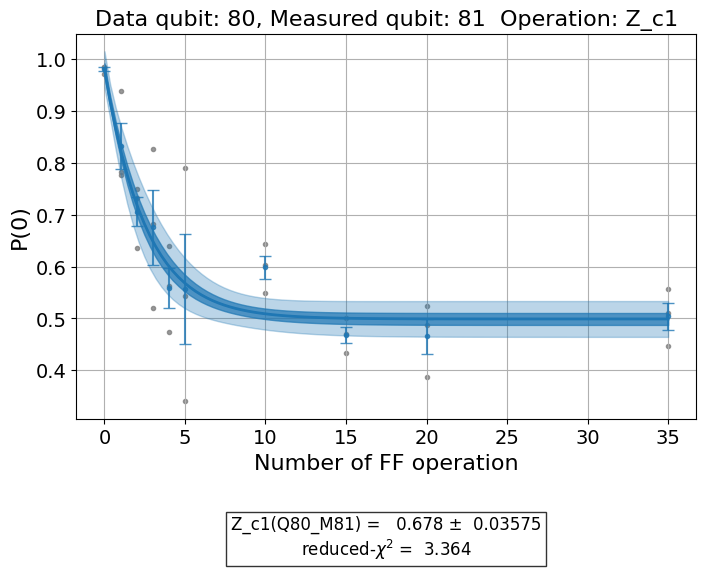

In [29]:
# plotting the decay curves of the first qubit
display(exp_data.figure(0))
display(exp_data.figure(6))
display(exp_data.figure(12))

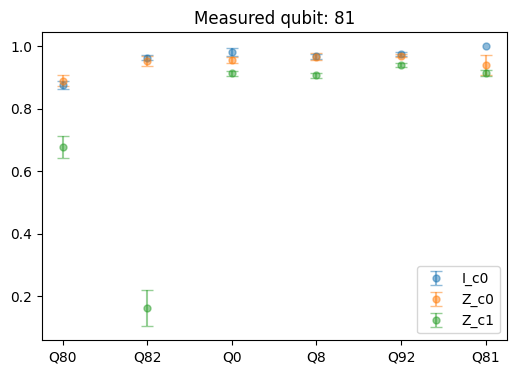

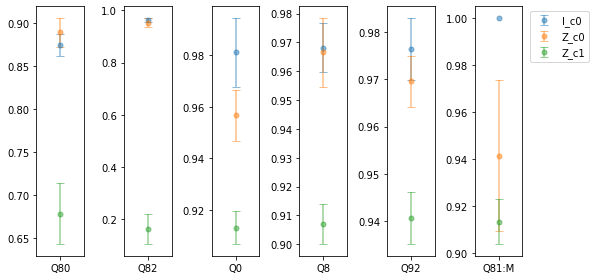

In [32]:
# summary plots
display(exp_data.figure(18))
display(exp_data.figure(19))

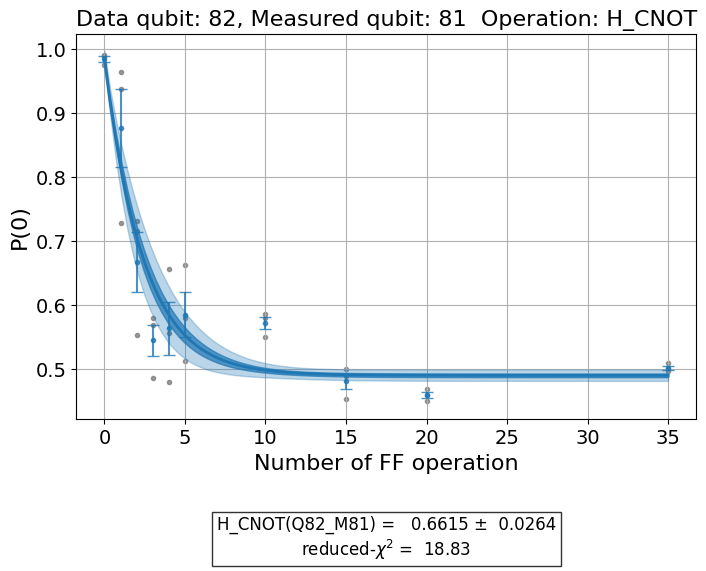

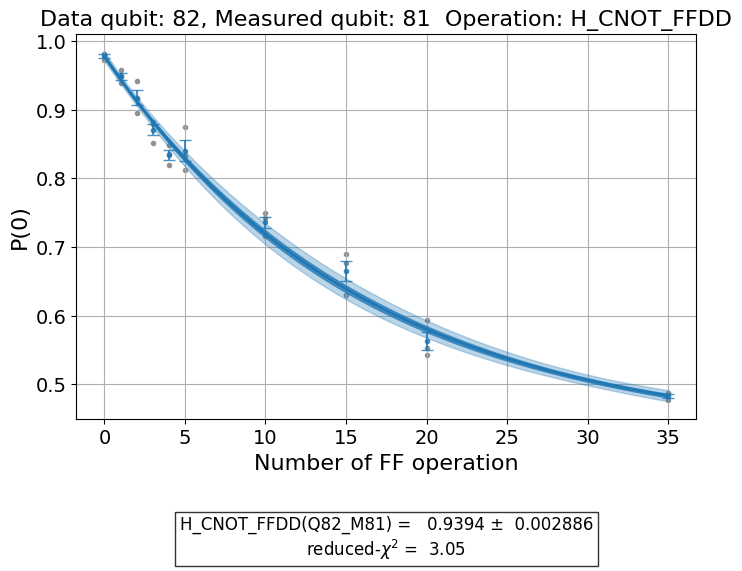

In [34]:
# Then showing the pairs experiments with and without DD
display(exp_data.figure(20))
display(exp_data.figure(21))

In [38]:
# analysis results
df = exp_data.analysis_results(dataframe=True)
df.head(25)

,name,experiment,components,value,quality,backend,run_time,chisq
2443f2bd,@Parameters_I_c0(Q80_M81),DynamicCircuitsRB,"[Q80, Q82, Q0, Q8, Q92, Q81]",CurveFitResult:\n - fitting method: least_squa...,good,ibm_pinguino1,None,None
b4527e89,I_c0(Q80_M81),DynamicCircuitsRB,"[Q80, Q82, Q0, Q8, Q92, Q81]",0.875+/-0.013,good,ibm_pinguino1,None,0.509311
d58d5e49,@Parameters_I_c0(Q82_M81),DynamicCircuitsRB,"[Q80, Q82, Q0, Q8, Q92, Q81]",CurveFitResult:\n - fitting method: least_squa...,bad,ibm_pinguino1,None,None
06e888be,I_c0(Q82_M81),DynamicCircuitsRB,"[Q80, Q82, Q0, Q8, Q92, Q81]",0.964+/-0.008,bad,ibm_pinguino1,None,5.168971
09a90f0e,@Parameters_I_c0(Q0_M81),DynamicCircuitsRB,"[Q80, Q82, Q0, Q8, Q92, Q81]",CurveFitResult:\n - fitting method: least_squa...,good,ibm_pinguino1,None,None
f33ec318,I_c0(Q0_M81),DynamicCircuitsRB,"[Q80, Q82, Q0, Q8, Q92, Q81]",0.981+/-0.013,good,ibm_pinguino1,None,0.436305
a50fe581,@Parameters_I_c0(Q8_M81),DynamicCircuitsRB,"[Q80, Q82, Q0, Q8, Q92, Q81]",CurveFitResult:\n - fitting method: least_squa...,bad,ibm_pinguino1,None,None
caba8824,I_c0(Q8_M81),DynamicCircuitsRB,"[Q80, Q82, Q0, Q8, Q92, Q81]",0.968+/-0.009,bad,ibm_pinguino1,None,9.94408
cec88fda,@Parameters_I_c0(Q92_M81),DynamicCircuitsRB,"[Q80, Q82, Q0, Q8, Q92, Q81]",CurveFitResult:\n - fitting method: least_squa...,good,ibm_pinguino1,None,None
568c1a57,I_c0(Q92_M81),DynamicCircuitsRB,"[Q80, Q82, Q0, Q8, Q92, Q81]",0.977+/-0.007,good,ibm_pinguino1,None,2.743871


In [39]:
import datetime
from IPython.display import HTML, display


def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += (
        "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    )
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))


qiskit_copyright()